# PBO learnt on several iterations and one weigth one the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
n_states = 17
n_actions = 2
n_repetitions = 10
n_samples = n_states * n_actions * n_repetitions
sucess_probability = 0.9
gamma = 0.9

# Weights collection
n_weights = 500

# Trainings
max_bellman_iterations = 5

## Linear PBO
training_steps = 200
fitting_steps = 2
batch_size_samples = n_states
batch_size_weights = n_weights
learning_rate = {"first": 0.01, "last": 0.001, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}
add_infinity_linear = True
add_infinity_non_linear = False

## Q-learning
fitting_steps_q = training_steps * fitting_steps
learning_rate_q = {"first": 0.01, "last": 0.001, "duration": fitting_steps_q * max_bellman_iterations * n_samples // batch_size_samples}

# Visualisation of errors and performances
max_bellman_iterations_validation = max_bellman_iterations + 20
horizon = 10

## Define environment

In [2]:
from pbo.environment.chain_walk import ChainWalkEnv

states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = np.arange(n_states + 1) - 0.5
actions_boxes = np.arange(n_actions + 1) - 0.5

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for _ in range(n_repetitions):
            env.reset(jnp.array([state]))
            next_state, reward, absorbing, _ = env.step(jnp.array([action]))

            replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

replay_buffer.cast_to_jax_array()

### Visualize samples

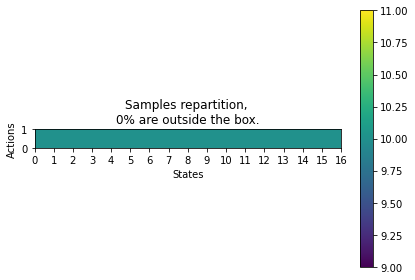

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes = count_samples(replay_buffer.states, replay_buffer.actions, states_boxes, actions_boxes)
samples_visu_mesh = TwoDimesionsMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Optimal Q function

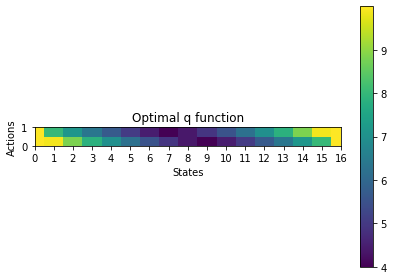

In [5]:
optimal_q = env.optimal_Q_mesh()

q_visu_mesh = TwoDimesionsMesh(states, actions, 0)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Train Q with Fitted-Q

In [6]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import TableQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = TableQ(
    1,
    n_states,
    1,
    n_actions,
    gamma,
    q_network_key,
    None,
    random_weights_key,
    learning_rate,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

training_losses_q = np.zeros(max_bellman_iterations)
validation_losses_q = np.zeros(max_bellman_iterations)
absording_probabilities_q = np.zeros((max_bellman_iterations, horizon))

params_target = q.params
q_i = q.discretize(q.to_weights(params_target).reshape((-1, q.weights_dimension)), states, actions)[0]

for bellman_iteration in tqdm(range(max_bellman_iterations)):
    for step in range(fitting_steps_q):
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, _ = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)

    q_i_plus_1 = q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_q[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_q[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    absording_probabilities_q[bellman_iteration] = env.absorbing_probability(policy_q, horizon)

    params_target = q.params
    q_i = q_i_plus_1
    print(policy_q)

  0%|          | 0/5 [00:00<?, ?it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]


## Optimal PBO

In [7]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_pbo import TabularPBO

data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

pbo_optimal = TabularPBO(q, max_bellman_iterations, False, pbo_network_key, learning_rate, n_actions)
pbo_optimal.params["TabularPBONet/linear"]["w"] = gamma * env.transition_proba.T
pbo_optimal.params["TabularPBONet/linear"]["b"] = env.PR.T

training_losses_optimal = np.zeros(max_bellman_iterations_validation)
validation_losses_optimal = np.zeros(max_bellman_iterations_validation)
absording_probabilities_optimal = np.zeros((max_bellman_iterations_validation, horizon))


batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo_optimal(pbo_optimal.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_optimal[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_optimal[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    absording_probabilities_optimal[bellman_iteration] = env.absorbing_probability(policy_q, horizon)
    print(policy_q)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]


## Collect weights

In [8]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q_random = TableQ(
    1,
    n_states,
    1,
    n_actions,
    gamma,
    q_network_key,
    None,
    random_weights_key,
    learning_rate=None,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_random.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train non linear PBO

In [9]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import TabularPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo_tabular = TabularPBO(q_random, max_bellman_iterations, add_infinity_non_linear, pbo_network_key, learning_rate, n_actions)
importance_iteration = jnp.ones(max_bellman_iterations + 1)
importance_iteration = importance_iteration.at[-1].set(0)

for _ in tqdm(range(training_steps)):
    params_target = pbo_tabular.params

    for _ in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo_tabular.params, pbo_tabular.optimizer_state, _ = pbo_tabular.learn_on_batch(
                    pbo_tabular.params, params_target, pbo_tabular.optimizer_state, batch_weights, batch_samples, importance_iteration
                )

training_losses_tabular = np.zeros(max_bellman_iterations_validation)
validation_losses_tabular = np.zeros(max_bellman_iterations_validation)
absording_probabilities_tabular = np.zeros((max_bellman_iterations_validation, horizon))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo_tabular(pbo_tabular.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_tabular[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_tabular[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    absording_probabilities_tabular[bellman_iteration] = env.absorbing_probability(policy_q, horizon)
    print(policy_q)

  0%|          | 0/200 [00:00<?, ?it/s]

[1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1]
[1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1]
[1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1]
[1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1]
[1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1]
[1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1]
[1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


## Train linear PBO

In [10]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity_linear, pbo_network_key, learning_rate)
importance_iteration = jnp.ones(max_bellman_iterations + 1)


for _ in tqdm(range(training_steps)):
    params_target = pbo.params
    for _ in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )

training_losses = np.zeros(max_bellman_iterations_validation)
validation_losses = np.zeros(max_bellman_iterations_validation)
absording_probabilities = np.zeros((max_bellman_iterations_validation, horizon))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    absording_probabilities[bellman_iteration] = env.absorbing_probability(policy_q, horizon)
    print(policy_q)

  0%|          | 0/200 [00:00<?, ?it/s]

[0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1]
[0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1]
[0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1]
[0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1]
[0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


## Visualize errors in Q functions

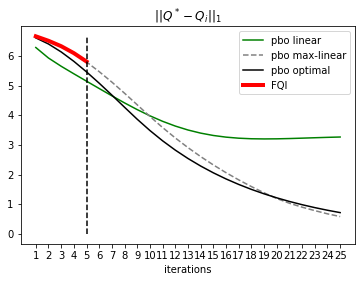

In [11]:
import matplotlib.pyplot as plt 

iterations = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations, validation_losses, label="pbo linear", color="green")
plt.plot(iterations, validation_losses_tabular, label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, validation_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), validation_losses_q, label="FQI", color="red", linewidth=4)
plt.vlines(max_bellman_iterations, 0, np.max(validation_losses_q), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| Q^* - Q_i ||_1$")
_ = plt.legend()

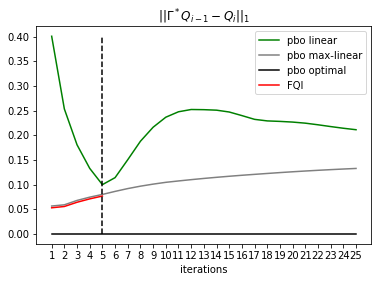

In [12]:
plt.plot(iterations, training_losses, label="pbo linear", color="green")
plt.plot(iterations, training_losses_tabular, label="pbo max-linear", color="grey")
plt.plot(iterations, training_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), training_losses_q, label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, np.maximum(np.max(training_losses_q), np.max(training_losses)), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_1$")
_ = plt.legend()

## Understanding the learning process

In [13]:
empirical_transition_proba = np.zeros((n_states, n_states * n_actions))

for idx_sample in range(len(replay_buffer.states)):
    state = replay_buffer.states[idx_sample, 0]
    action = replay_buffer.actions[idx_sample, 0]
    next_state = replay_buffer.next_states[idx_sample, 0]

    empirical_transition_proba[next_state, state * n_actions + action] += 1 

empirical_transition_proba /= n_repetitions


In [14]:
np.linalg.norm(empirical_transition_proba - pbo_tabular.params["TabularPBONet/linear"]["w"] / gamma)

0.078189574

## Visualize errors in preformances

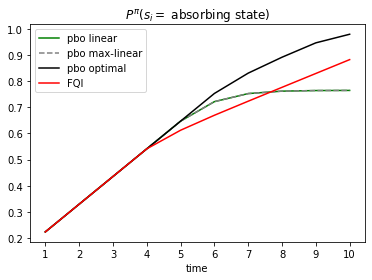

In [15]:
iteration = 5
time = range(1, horizon + 1)


plt.plot(time, absording_probabilities[iteration], label="pbo linear", color="green")
plt.plot(time, absording_probabilities_tabular[iteration], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(time, absording_probabilities_optimal[iteration], label="pbo optimal", color="black")
plt.plot(time, absording_probabilities_q[min([iteration, max_bellman_iterations - 1])], label="FQI", color="red")

plt.xticks(time)
plt.xlabel("time")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)")
_ = plt.legend()

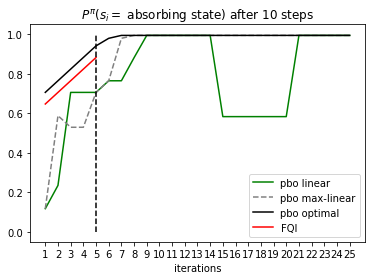

In [16]:
iteration = 1


plt.plot(iterations, absording_probabilities[:, -1], label="pbo linear", color="green")
plt.plot(iterations, absording_probabilities_tabular[:, -1], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, absording_probabilities_optimal[:, -1], label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), absording_probabilities_q[:, -1], label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, 1, color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)" + f" after {horizon} steps")
_ = plt.legend()